In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import logging


In [3]:
import qt3utils.experiments.podmr
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [4]:
logging.basicConfig(level=logging.WARNING)

In [5]:
qt3utils.experiments.podmr.logger.setLevel(logging.INFO)

# Create objects to control the hardware

In [6]:
pulser = qcsapphire.Pulser('COM4')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [7]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# Instantiate an experiment object

In [16]:
experiment = qt3utils.experiments.podmr.PulsedODMR(pulser, rfsynth, nidaq_config, 
                                                   photon_counter_nidaq_terminal = 'PFI0',
                                                   clock_nidaq_terminal = 'PFI12',
                                                   rf_width = .5e-6, rf_power = -10)

In [22]:
experiment.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -10,
 'rf_width': 5e-07,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 2e-05,
 'rf_pulse_justify': 'center',
 'clock_period': 2e-07}

In [23]:
experiment.rf_pulse_justify = 'start_center' #options are left, center, right, start_center

In [24]:
scan_data = experiment.run(N_cycles=10000)

INFO:qt3utils.experiments.podmr:RF frequency: 2.8200000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.821 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.822 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.823 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.8240000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.825 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.826 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.827 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.8280000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.829 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.83 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.831 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.8320000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.833 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.834 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.835 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.83600

# Observe the Data

In [12]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate, label = label)

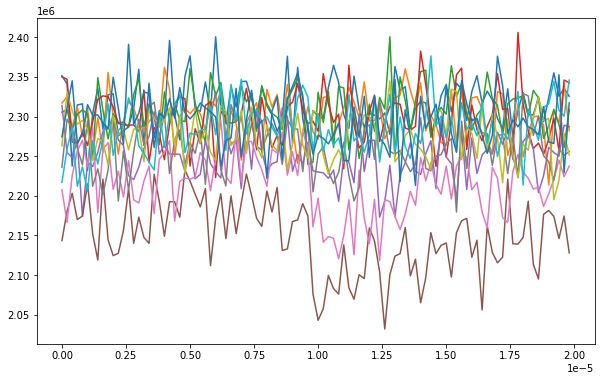

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

for scan in scan_data[::10]:
    
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = scan[0])
    
# for freq in list(combined_scans.keys())[::5]:
#     plot_trace(combined_scans[freq], cwodmr.N_cycles, clock_rate = 1./cwodmr.clock_period)

In [28]:
def get_trace(scan_data, freq = 2870e6):
    frequencies = np.array([x[0] for x  in scan_data ])
    res_index = np.where(np.isclose(frequencies,freq))
    scan = scan_data[int(res_index[0])]
    return scan

In [31]:
def plot_frequency(scan_data,  freq = 2870e6):
    freq, trace = get_trace(scan_data, freq)
    plot_trace(trace, experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = freq)

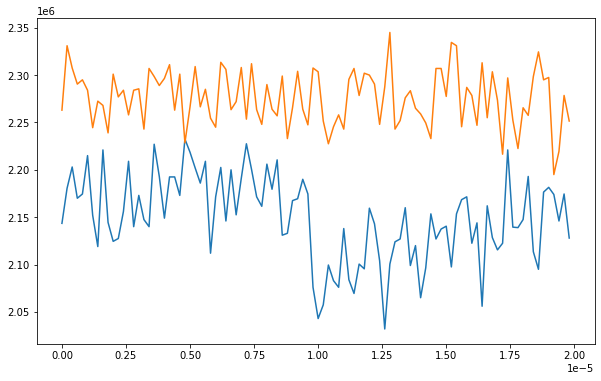

In [32]:
fig, ax = plt.subplots(figsize=(10,6))

# on resonance
plot_frequency(scan_data, 2870e6)

# off resonance
plot_frequency(scan_data, 2900e6)

# Analyze Data

In [34]:
freq, trace = get_trace(scan_data)

In [43]:
def lockin_amp_like_analysis(trace):
    signal = trace[-len(trace)//2:]
    background = trace[:len(trace)//2]
    return np.sum(signal)/np.sum(background)

In [44]:
lockin_amp_like_analysis(trace)

0.977155106979055

In [45]:
freq, trace = get_trace(scan_data, 2.911e9 )

In [47]:
lockin_amp_like_analysis(trace)

0.9999432965633356

In [11]:
def signal_to_background(trace, pre_trigger, aom_width, rf_width, post_rf_pad, verbose=False,
                        signal_aom_width_duty = 1.0, background_aom_width_duty = 1.0,
                        aggregation = np.sum):
    '''
    Assumes trace produced by qt3utils.experiments.rabi.Rabi class and
    is the aggregated data for a particular RF width.

    The inputs `pre_trigger`, `aom_width` and `rf_width` are all in units of index of the trace.
    That is, they are in units of clock ticks.

    Assumes that trace is of shape
        * pre_trigger
        * aom_width: aom on / rf off (background)
        * rf_width:  aom off / rf on
        * aom_width: aom on/ rf off  (signal)

    returns sum(signal) / sum(background)

    '''
    background_end = pre_trigger + int(aom_width*background_aom_width_duty)
    signal_start = pre_trigger + aom_width + rf_width + post_rf_pad
    signal_end = signal_start + int(aom_width*signal_aom_width_duty)

    background = aggregation(trace[pre_trigger:background_end])
    signal = aggregation(trace[signal_start:signal_end])

    if verbose:
        print(f'inputs. pre_trigger = {pre_trigger}, aom_width = {aom_width}, rf_width = {rf_width}')
        print(f'        signal_duty = {signal_aom_width_duty}, bkgd_duty = {background_aom_width_duty}')
        print(f'        aggregation = {aggregation}')
        print(f'background: {pre_trigger} -> {background_end}')
        print(trace[pre_trigger:background_end])
        print(f'signal: {signal_start} -> {signal_end}')
        print(trace[signal_start:signal_end])

    return signal / background



In [12]:
def build_contrast(single_scan, clock_period, aom_width_time, rf_width_time, post_rf_pad, 
                   pre_trigger = 2, signal_duty=0.25, background_duty=0.25, verbose = False):

    contrast = []
    if verbose:
        print(clock_period)
        print(aom_width_time)
        print(post_rf_pad)
    for measurement in single_scan:
        
        rf_frequency = measurement[0]
        #N_samples_per_cycle = measurement[1]
        #clock_period = rabi.clock_period
        #aom_width_time = rabi.aom_width
        summed_trace = measurement[2]
 
        aom_width_ticks = int(aom_width_time / clock_period)
        rf_width_ticks = int(rf_width_time / clock_period)
        # post_rf_pad_ticks = np.round(rabi.post_rf_pad / clock_period).astype(int)
        post_rf_pad_ticks = int(post_rf_pad / clock_period)

        c = signal_to_background(summed_trace, 
                                 pre_trigger, 
                                 aom_width_ticks, 
                                 rf_width_ticks, 
                                 post_rf_pad_ticks,
                                 signal_aom_width_duty = signal_duty, 
                                 background_aom_width_duty = background_duty , aggregation = np.mean, verbose=verbose)

        contrast.append([rf_frequency, c]) 

    contrast = np.array(contrast)
    return contrast

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -30,
 'rf_width': 5e-07,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 2e-05,
 'rf_pulse_justify': 'center',
 'clock_period': 2e-07}

## Change some parameters if you wish

In [35]:
experiment.aom_width = 3e-6
experiment.rf_width = 1.5e-6 # let's say 1.5 microseconds pi pulse
experiment.full_cycle_width = experiment.aom_width + 2*experiment.rf_width #be careful with this... check the oscilloscope if you
#get funny results below. the QC sapphire can sometimes get into weird states

experiment.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -30,
 'rf_width': 1.5e-06,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 6e-06,
 'rf_pulse_justify': 'center',
 'clock_period': 2e-07}

In [37]:
# uncomment if you want to remove the log statements in the loop below
# qt3utils.experiments.podmr.logger.setLevel(logging.WARNING)

# Take Data

In [39]:
experiment.rfsynth.rf_on(experiment.rfsynth_channel)
time.sleep(2)

full_scans = []

for i in range(1):
    if i % 5 == 0:
        print(i)
    scan_data = experiment.run(N_cycles=1000, post_process_function=aggregate_mean_data, reverse=(i%2==0))
    full_scans.append(scan_data)
    
    #scan_data = rabi.run(N_cycles = 100000, post_process_function=aggregate_mean_data)

0


## Massage the data

In [40]:
reconstructed_single_scan = recombine_scans(full_scans)

In [41]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

### doing some data checks

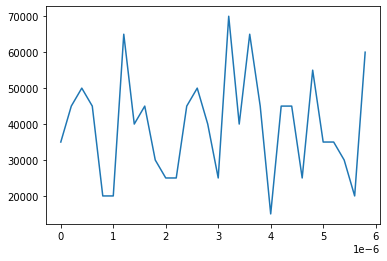

In [44]:
scan = reconstructed_single_scan[10]
plot_rolled_trace(scan[-1], clock_rate = 1/experiment.clock_period)

In [45]:
pre_trigger = 2
aom_width = int(experiment.aom_width / experiment.clock_period)
#rf_delay = int((experiment.aom_response_time  + experiment.pre_rf_pad)/experiment.clock_period)
rf_width = int(experiment.rf_width / experiment.clock_period)
post_rf_pad = int(experiment.post_rf_pad / experiment.clock_period)

print(aom_width)
#print(rf_delay)
print(rf_width)
print(post_rf_pad)
print(scan[-1])
print('function')

signal_to_background(scan[-1], pre_trigger, aom_width, rf_width, post_rf_pad, verbose=True)

15
7
0
[0.007 0.009 0.01  0.009 0.004 0.004 0.013 0.008 0.009 0.006 0.005 0.005
 0.009 0.01  0.008 0.005 0.014 0.008 0.013 0.009 0.003 0.009 0.009 0.005
 0.011 0.007 0.007 0.006 0.004 0.012]
function
inputs. pre_trigger = 2, aom_width = 15, rf_width = 7
        signal_duty = 1.0, bkgd_duty = 1.0
        aggregation = <function sum at 0x000001EAAB0ECE50>
background: 2 -> 17
[0.01  0.009 0.004 0.004 0.013 0.008 0.009 0.006 0.005 0.005 0.009 0.01
 0.008 0.005 0.014]
signal: 24 -> 39
[0.011 0.007 0.007 0.006 0.004 0.012]


0.3949579831932773

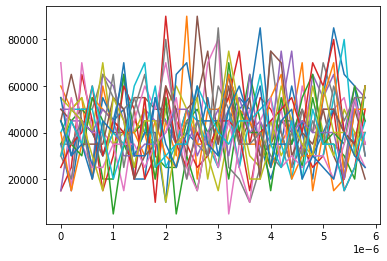

In [46]:
for scan in reconstructed_single_scan[::5]:
    plot_rolled_trace(scan[-1], clock_rate = 1/experiment.clock_period)

# Compute contrast

In [135]:
contrast = build_contrast(reconstructed_single_scan, experiment.clock_period, 
                          experiment.aom_width, experiment.rf_width,
                          experiment.post_rf_pad, signal_duty=.5, background_duty=.5)
x_data = contrast[:, 0]
y_data = contrast[:, 1]

# Plot Contrast

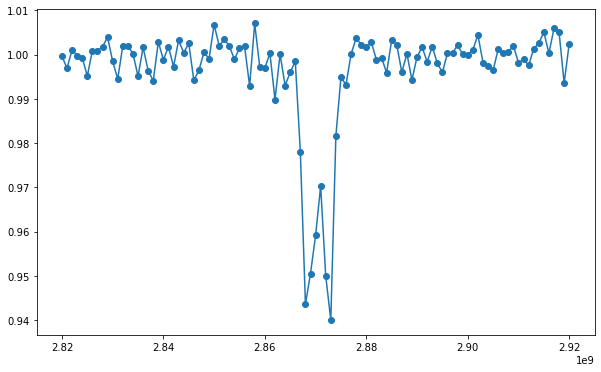

In [136]:


plt.figure(figsize=(10, 6))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

# plt.xlabel('microseconds')
# plt.ylabel('signal/background')
# plt.plot(x_data, rabi_oscillation(x_data, *params),
#          label='Fitted function', color='orange')
# plt.legend()

In [139]:
x_data[y_data<0.95]

array([2.868e+09, 2.873e+09])